# iFood CRM Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import re
from sklearn.impute import KNNImputer
from datetime import date
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [2]:
# Load the main dataset
data = pd.read_csv('marketing_data.csv', index_col='ID', parse_dates=['Dt_Customer'])

data = data.rename(columns={
    'Dt_Customer':'Enrollment_Date',
    'Recency':'Days_Last_Purchase',
    ' Income ':'Income'})

data['ID'] = data.index

data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Enrollment_Date,Days_Last_Purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1826,1970,Graduation,Divorced,"$84,835.00",0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP,1826
1,1961,Graduation,Single,"$57,091.00",0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA,1
10476,1958,Graduation,Married,"$67,267.00",0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US,10476
1386,1967,Graduation,Together,"$32,474.00",1,1,2014-05-11,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,1386
5371,1989,Graduation,Single,"$21,474.00",1,0,2014-04-08,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP,5371


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 1826 to 4070
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2240 non-null   int64         
 1   Education            2240 non-null   object        
 2   Marital_Status       2240 non-null   object        
 3   Income               2216 non-null   object        
 4   Kidhome              2240 non-null   int64         
 5   Teenhome             2240 non-null   int64         
 6   Enrollment_Date      2240 non-null   datetime64[ns]
 7   Days_Last_Purchase   2240 non-null   int64         
 8   MntWines             2240 non-null   int64         
 9   MntFruits            2240 non-null   int64         
 10  MntMeatProducts      2240 non-null   int64         
 11  MntFishProducts      2240 non-null   int64         
 12  MntSweetProducts     2240 non-null   int64         
 13  MntGoldProds         2240 non-

In [4]:
# Store customer's information
Customers = data.loc[:,:'Days_Last_Purchase'].join(data[['Country']])  

# Store product's information
Products = data.loc[:,'MntWines':'MntGoldProds']     

# Store Purchases' information
Purchases = data.loc[:,'NumDealsPurchases':'NumWebVisitsMonth']    

# Store campaign's information
Campaigns = data.loc[:,'AcceptedCmp3':'AcceptedCmp2']     
Misc = data.loc[:,['Response','Complain']]

In [5]:
pd.DataFrame(data.isnull().sum(), columns=['Null_Values'])

,Null_Values
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Enrollment_Date,0
Days_Last_Purchase,0
MntWines,0
MntFruits,0


## Data Cleaning

In [6]:
def extract(x):
    if x is np.nan: return np.nan
    return float(re.sub(r'[$,]', "", str(x)))

data['Income'] = data['Income'].apply(extract)

In [7]:
category = data.select_dtypes(include='object')
numeric = data.select_dtypes(exclude='object')

In [8]:
for f in category.columns:
    print(category[f].value_counts())
    print('***********************************')

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
***********************************
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
***********************************
SP     1095
SA      337
CA      268
AUS     160
IND     148
GER     120
US      109
ME        3
Name: Country, dtype: int64
***********************************


In [9]:
numeric_before_impute = numeric.drop(['Year_Birth', 'Enrollment_Date', 'ID'], axis=1).copy()
imputer = KNNImputer(missing_values=np.nan)
numeric_imputed = imputer.fit_transform(numeric_before_impute)

numeric_imputed = pd.DataFrame(numeric_imputed, 
                       index=numeric_before_impute.index, 
                       columns=numeric_before_impute.columns).join(numeric[['Year_Birth', 'Enrollment_Date', 'ID']])
numeric = numeric_imputed

In [10]:
numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2240.0,52232.900982,25116.603546,1730.0,35409.00,51369.0,68413.25,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Days_Last_Purchase,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0
MntGoldProds,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0


In [11]:
Age = date.today().year-numeric['Year_Birth']
numeric.insert(1, 'Age', Age,)

Age_Enrollment = numeric['Enrollment_Date'].dt.year - numeric['Year_Birth']
numeric.insert(6, 'Age_Enrollment', Age_Enrollment)

In [12]:
numeric.head()

,Income,Age,Kidhome,Teenhome,Days_Last_Purchase,MntWines,Age_Enrollment,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Year_Birth,Enrollment_Date,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1826,84835.0,52,0.0,0.0,0.0,189.0,44,104.0,379.0,111.0,189.0,218.0,1.0,4.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1970,2014-06-16,1826
1,57091.0,61,0.0,0.0,0.0,464.0,53,5.0,64.0,7.0,0.0,37.0,1.0,7.0,3.0,7.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1961,2014-06-15,1
10476,67267.0,64,0.0,1.0,0.0,134.0,56,11.0,59.0,15.0,2.0,30.0,1.0,3.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1958,2014-05-13,10476
1386,32474.0,55,1.0,1.0,0.0,10.0,47,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1967,2014-05-11,1386
5371,21474.0,33,1.0,0.0,0.0,6.0,25,16.0,24.0,11.0,0.0,34.0,2.0,3.0,1.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1989,2014-04-08,5371


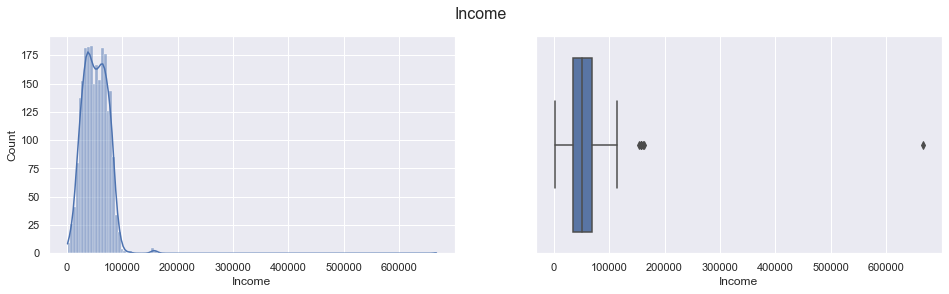

count      2240.000000
mean      52232.900982
std       25116.603546
min        1730.000000
25%       35409.000000
50%       51369.000000
75%       68413.250000
max      666666.000000
Name: Income, dtype: float64


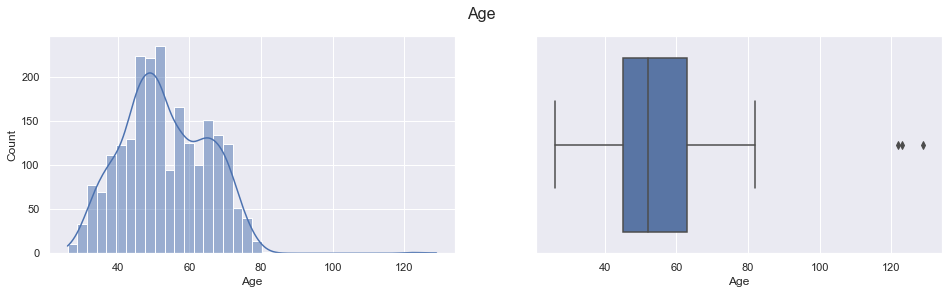

count    2240.000000
mean       53.194196
std        11.984069
min        26.000000
25%        45.000000
50%        52.000000
75%        63.000000
max       129.000000
Name: Age, dtype: float64


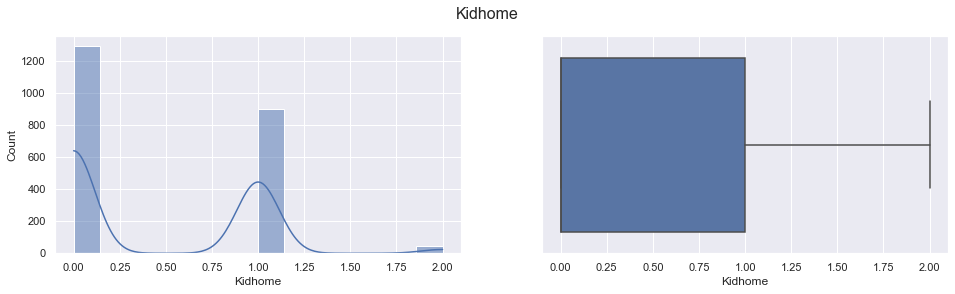

count    2240.000000
mean        0.444196
std         0.538398
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Kidhome, dtype: float64


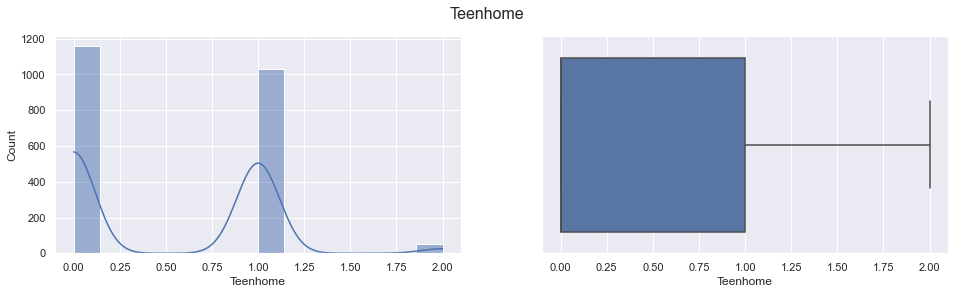

count    2240.000000
mean        0.506250
std         0.544538
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Teenhome, dtype: float64


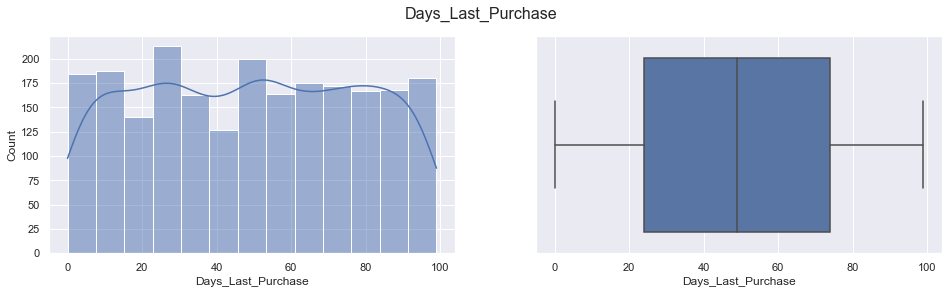

count    2240.000000
mean       49.109375
std        28.962453
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Days_Last_Purchase, dtype: float64


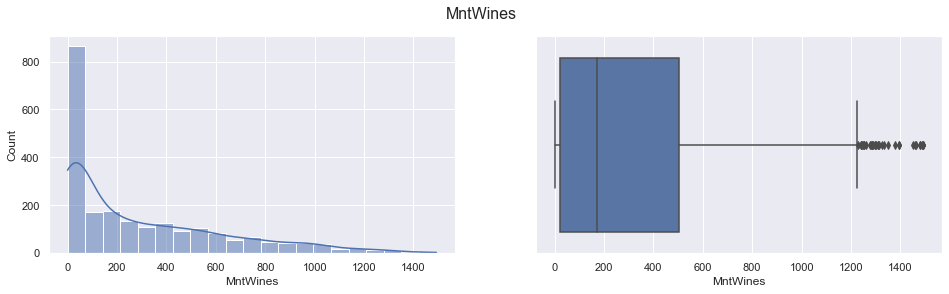

count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
25%        23.750000
50%       173.500000
75%       504.250000
max      1493.000000
Name: MntWines, dtype: float64


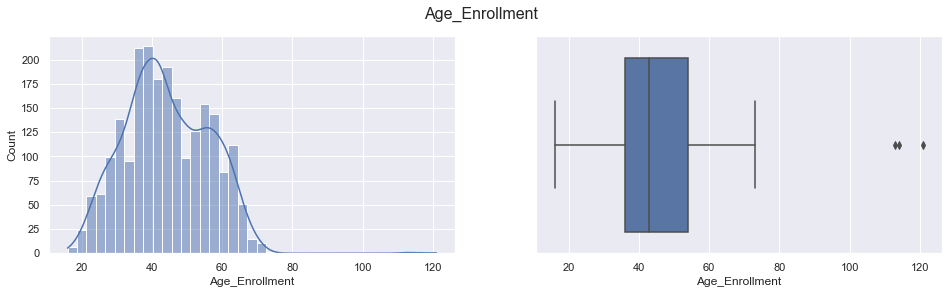

count    2240.000000
mean       44.222321
std        12.022855
min        16.000000
25%        36.000000
50%        43.000000
75%        54.000000
max       121.000000
Name: Age_Enrollment, dtype: float64


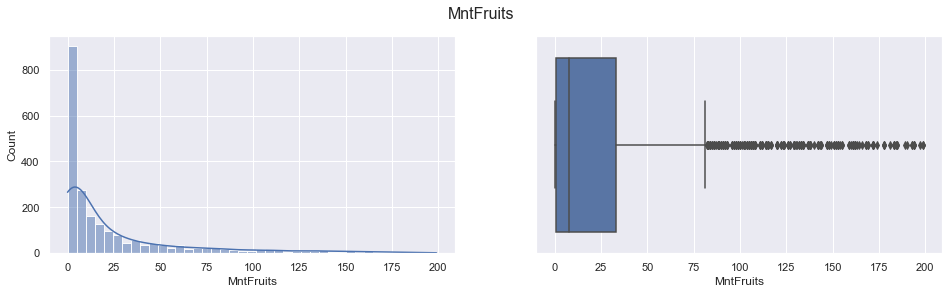

count    2240.000000
mean       26.302232
std        39.773434
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64


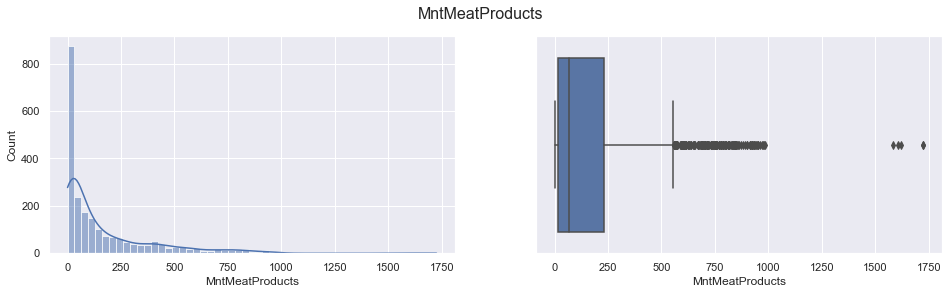

count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64


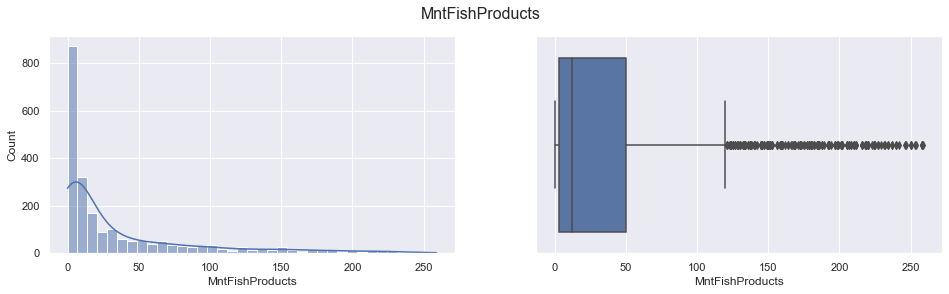

count    2240.000000
mean       37.525446
std        54.628979
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishProducts, dtype: float64


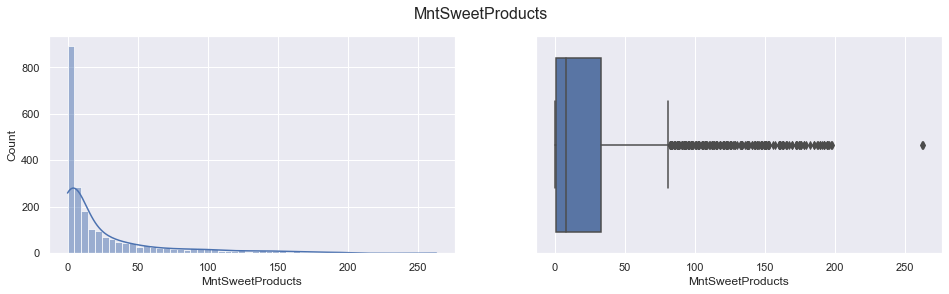

count    2240.000000
mean       27.062946
std        41.280498
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       263.000000
Name: MntSweetProducts, dtype: float64


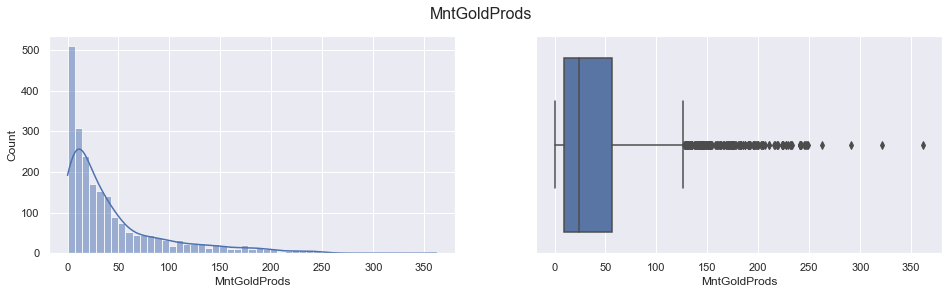

count    2240.000000
mean       44.021875
std        52.167439
min         0.000000
25%         9.000000
50%        24.000000
75%        56.000000
max       362.000000
Name: MntGoldProds, dtype: float64


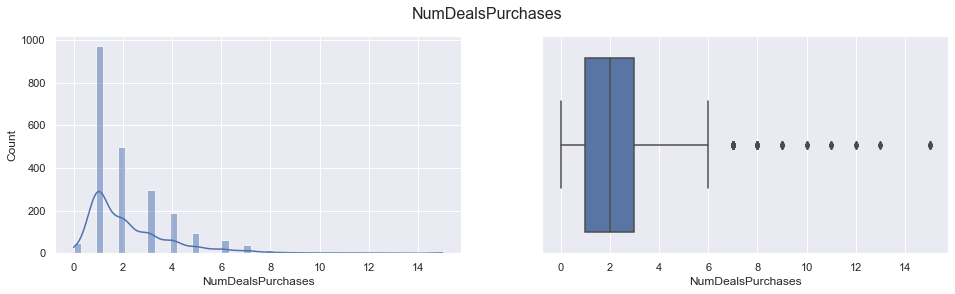

count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64


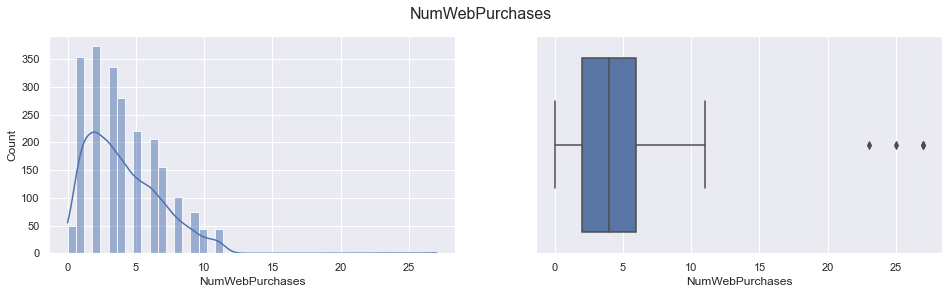

count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64


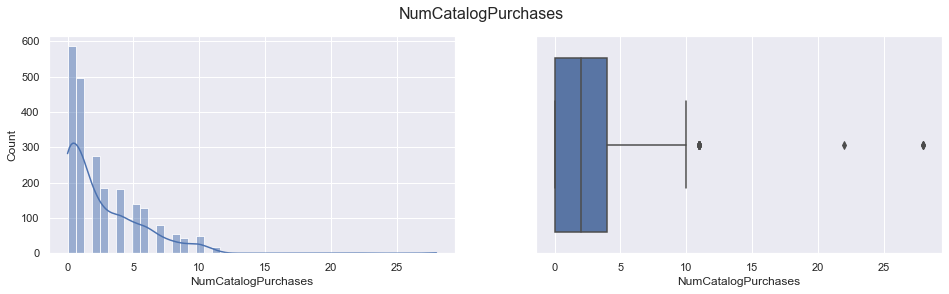

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64


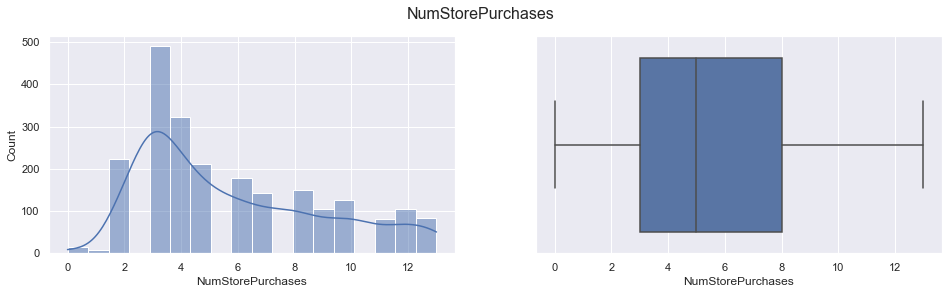

count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64


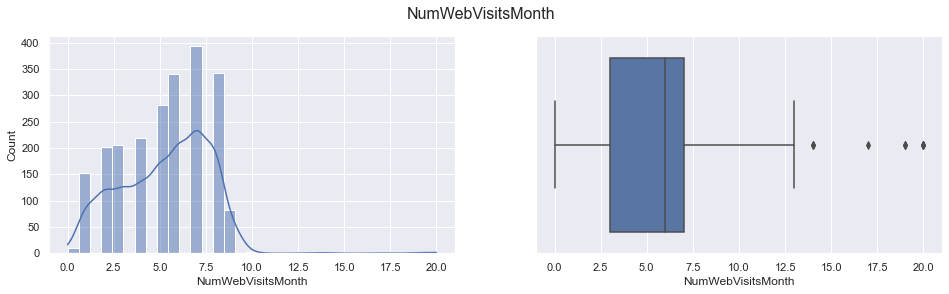

count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64


In [13]:
for col in numeric.columns:
    if col in ['Year_Birth','Enrollment date']:
        continue
    if col == 'AcceptedCmp3': 
        break
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,4)
    fig.suptitle(col, fontsize=16)
    sns.histplot(data=numeric, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=numeric, x=col, ax=ax[1])
    plt.show()

    print(numeric[col].describe())

In [14]:
numeric[numeric['Age']>80]

,Income,Age,Kidhome,Teenhome,Days_Last_Purchase,MntWines,Age_Enrollment,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Year_Birth,Enrollment_Date,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
11004,60182.0,129,0.0,1.0,23.0,8.0,121,0.0,5.0,7.0,0.0,2.0,1.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1893,2014-05-17,11004
1150,83532.0,123,0.0,0.0,36.0,755.0,114,144.0,562.0,104.0,64.0,224.0,1.0,4.0,6.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1899,2013-09-26,1150
6932,93027.0,81,0.0,0.0,77.0,1285.0,72,42.0,716.0,55.0,0.0,21.0,0.0,7.0,10.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1941,2013-04-13,6932
6663,51141.0,82,0.0,0.0,96.0,144.0,73,0.0,7.0,0.0,0.0,6.0,1.0,3.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1940,2013-07-08,6663
7829,36640.0,122,1.0,0.0,99.0,15.0,113,6.0,8.0,7.0,4.0,25.0,1.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1900,2013-09-26,7829


In [15]:
temp = numeric[numeric['Age']>120].index
numeric.loc[temp, ["Year_Birth", "Age", "Age_Enrollment"]] = np.nan

In [16]:
numeric[numeric['Income']>160000]

,Income,Age,Kidhome,Teenhome,Days_Last_Purchase,MntWines,Age_Enrollment,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Year_Birth,Enrollment_Date,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1501,160803.0,40.0,0.0,0.0,21.0,55.0,30.0,16.0,1622.0,17.0,3.0,4.0,15.0,0.0,28.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1982.0,2012-08-04,1501
9432,666666.0,45.0,1.0,0.0,23.0,9.0,36.0,14.0,18.0,8.0,1.0,12.0,4.0,3.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,2013-06-02,9432
1503,162397.0,46.0,1.0,1.0,31.0,85.0,37.0,1.0,16.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976.0,2013-06-03,1503


## Analysis

### Enrollment

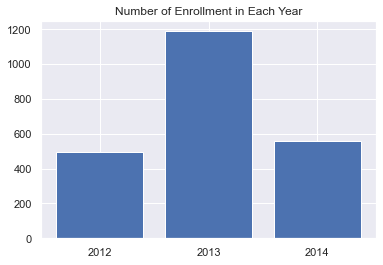

In [17]:
plt.bar(height = numeric['Enrollment_Date'].dt.year.value_counts()[[2012,2013,2014]], x=['2012','2013','2014'])
plt.title('Number of Enrollment in Each Year')
plt.show()

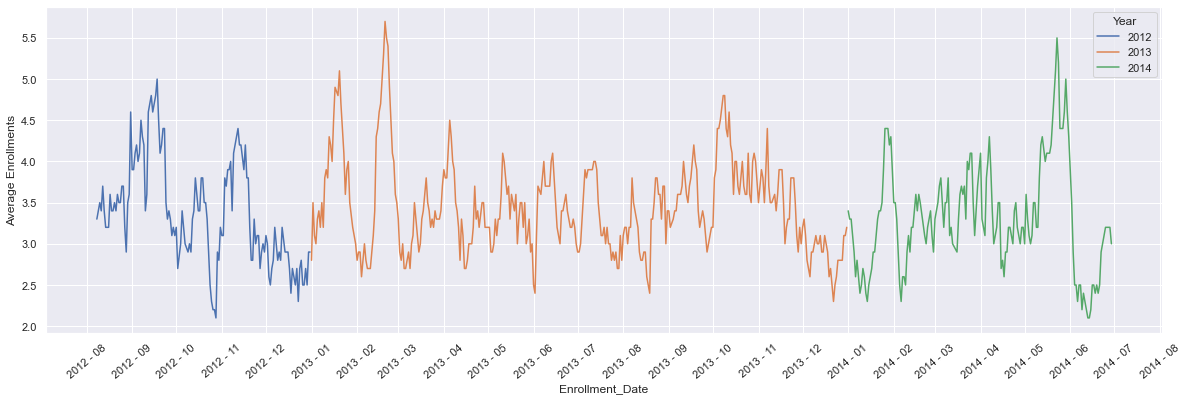

In [18]:
df = pd.pivot_table(numeric, values='ID', index='Enrollment_Date', aggfunc='count')
df['count'] = df['ID'].rolling(10).mean()
df['Year'] = df.index.year.astype('category')

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

sns.lineplot(data=df, x='Enrollment_Date', y='count', ax=ax, hue='Year')
ax.set_ylabel('Average Enrollments')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y - %m'))
plt.xticks(rotation=40)
plt.show()

### Income

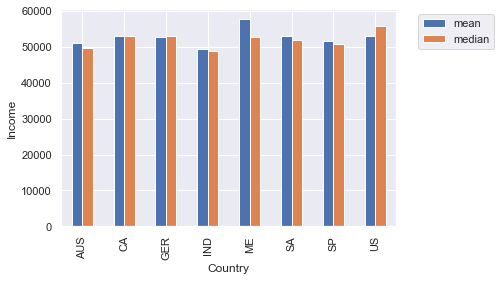

In [19]:
# This time, we need to exclude the outlier in "Income" column before caculating any statistics.
numeric_analysis = numeric[numeric['Income']!=666666]

df = pd.pivot_table(numeric_analysis.join(category[['Country']]), 
                     values='Income', 
                     index='Country', 
                     aggfunc={'Income':['mean','median']})
df.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Income')
plt.show()

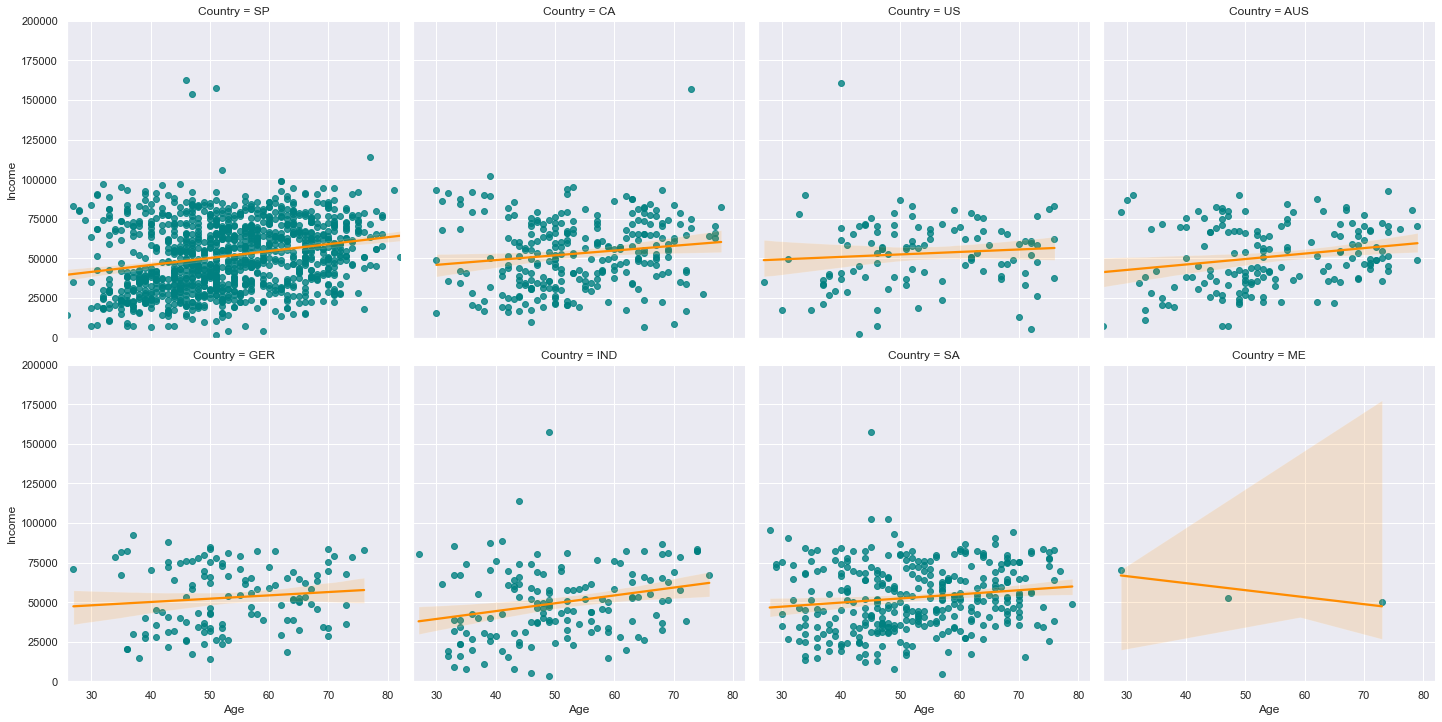

In [20]:
temp = numeric_analysis[['Income','Age']].join(category[['Country']])
sns.lmplot(data=temp, y='Income', x='Age', col='Country', col_wrap=4, line_kws={'color': 'darkorange'}, scatter_kws={'color':'teal'})
plt.ylim(0,200000)
plt.show()

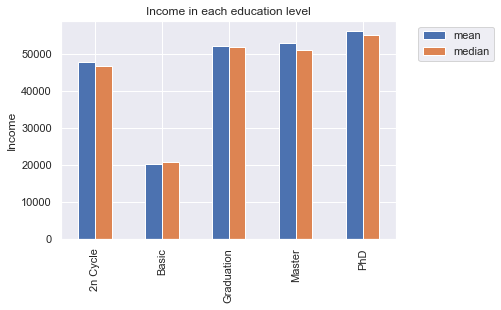

,count,mean,median
Education,,,
2n Cycle,203,47848.976355,46779.0
Basic,54,20306.259259,20744.0
Graduation,1126,52099.009236,51844.5
Master,370,53009.959459,50954.0
PhD,486,56065.807819,55185.0


In [21]:
df = pd.pivot_table(numeric_analysis.join(category[['Education']]), 
               values='Income', 
               index='Education', 
               aggfunc={'Income':['count','mean','median']})

df[['mean','median']].plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Income')
plt.xlabel('')
plt.title('Income in each education level')
plt.show()

df

In [22]:
del numeric_analysis

### Purchases

In [23]:
numeric['Total products amount'] = np.sum(Products, axis=1)

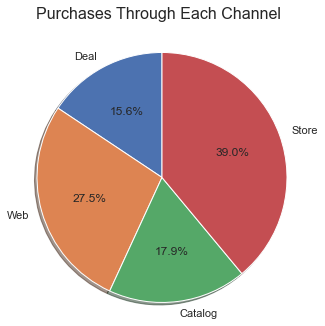

NumStorePurchases      38.959479
NumWebPurchases        27.484906
NumCatalogPurchases    17.911748
NumDealsPurchases      15.643868
dtype: float64


In [24]:
total_purchase_each = np.sum(Purchases.iloc[:,:-1], axis=0)

percent_purchase_each = total_purchase_each/np.sum(total_purchase_each)*100

def plot_pie_chart(labels, sizes: pd.Series, title):
    fig, ax = plt.subplots()
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(5,5)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.axis('equal')  
    plt.show()
    print(sizes.sort_values(ascending=False))
    

plot_pie_chart(labels=['Deal','Web','Catalog','Store'], sizes=percent_purchase_each, title='Purchases Through Each Channel')

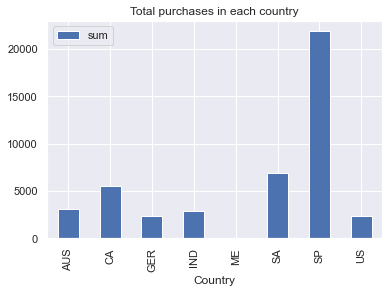

In [25]:
if 'Total purchase' not in Purchases.columns:
    Purchases['Total purchase'] = np.sum(Purchases, axis=1)

Purchase_category = Purchases.join(category)

Purchase_country_summary = pd.pivot_table(Purchase_category, 
                                          values='Total purchase', 
                                          index='Country', 
                                          aggfunc={'Total purchase':['sum']})

Purchase_country_summary.plot(kind='bar')
plt.title('Total purchases in each country')
plt.show()

### Products

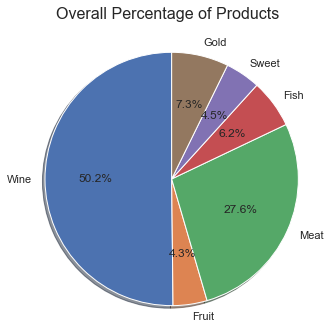

MntWines            50.171114
MntMeatProducts     27.558681
MntGoldProds         7.266755
MntFishProducts      6.194380
MntSweetProducts     4.467320
MntFruits            4.341748
dtype: float64


In [26]:
sum_each_product = np.sum(Products, axis=0)

plot_pie_chart(sizes=sum_each_product/np.sum(sum_each_product)*100, 
               labels=['Wine','Fruit','Meat','Fish','Sweet','Gold'],
              title='Overall Percentage of Products')

### Campaign

In [27]:
each_campaign = np.sum(Campaigns,axis=0)

CR_each_canpaign = each_campaign/len(Campaigns)*100

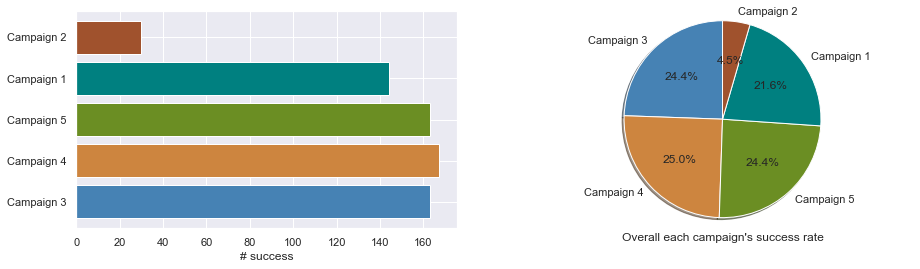

In [28]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,4)

cam_color = ['steelblue','peru','olivedrab','teal','sienna']

ax[0].barh(y=['Campaign 3','Campaign 4','Campaign 5','Campaign 1','Campaign 2'], 
           width=each_campaign.values, color=cam_color)
ax[0].set_xlabel('# success')

ax[1].pie(x=CR_each_canpaign, labels=['Campaign 3','Campaign 4','Campaign 5','Campaign 1','Campaign 2'],
         autopct='%1.1f%%', shadow=True, startangle=90, colors=cam_color)
ax[1].axis('equal')
ax[1].set_xlabel('Overall each campaign\'s success rate')

plt.show()

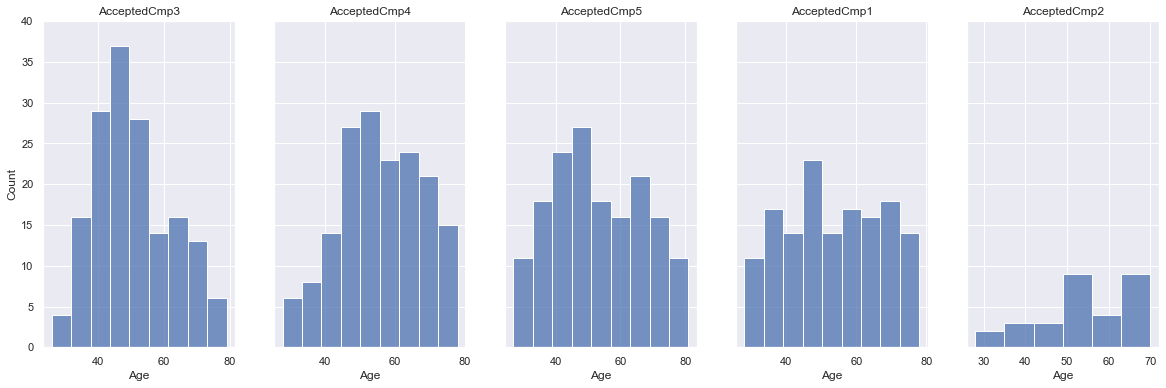

In [29]:
fig, ax = plt.subplots(1,len(Campaigns.columns), sharey=True)
i=0
fig.set_size_inches(20,6)

for campaign in Campaigns.columns:
    sns.histplot(data=numeric[numeric[campaign]==1], x = 'Age', ax=ax[i])
    ax[i].set_ylim(0,40)
    ax[i].set_title(campaign)    
    i+=1
    
plt.show()

In [30]:
Campaigns_category = Campaigns.join(category)
Campaigns_category['Total accept'] = np.sum(Campaigns, axis=1)

summary_country = pd.pivot_table(Campaigns_category, 
                                   values='Total accept', 
                                   index='Country', 
                                   aggfunc={'Total accept':['sum','count']})

summary_country['Conversion Rate'] = summary_country['sum']/summary_country['count']
summary_country.rename(columns={'count':'Number of Customers', 'sum':'Total Accepted'}).style.background_gradient(sns.light_palette('khaki', as_cmap=True), 
                                                                                                       subset=pd.IndexSlice[:, ['Conversion Rate']])

,Number of Customers,Total Accepted,Conversion Rate
Country,,,
AUS,160,35,0.218750
CA,268,87,0.324627
GER,120,38,0.316667
IND,148,39,0.263514
ME,3,1,0.333333
SA,337,86,0.255193
SP,1095,355,0.324201
US,109,26,0.238532


In [31]:
temp = Campaigns_category.groupby(by='Country').agg(['mean'])
temp.drop(['ME'], axis=0, inplace=True)  # since "ME" have only 3 observations, I decided to drop it in this table.
temp.style.background_gradient(sns.light_palette('green', as_cmap=True))

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Total accept
,mean,mean,mean,mean,mean,mean
Country,,,,,,
AUS,0.056250,0.037500,0.081250,0.043750,0.000000,0.218750
CA,0.067164,0.089552,0.078358,0.067164,0.022388,0.324627
GER,0.083333,0.091667,0.066667,0.058333,0.016667,0.316667
IND,0.087838,0.074324,0.040541,0.047297,0.013514,0.263514
SA,0.062315,0.059347,0.062315,0.059347,0.011869,0.255193
SP,0.075799,0.081279,0.081279,0.071233,0.014612,0.324201
US,0.073394,0.055046,0.045872,0.064220,0.000000,0.238532
